In [1]:
# Loading and parsing data

# PLOT - parse data + std-dev
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import ticker
from scipy import stats

plt.style.use('seaborn')
sns.set(rc={'figure.figsize':(8,4)})
sns.set_style("whitegrid")

data_path = os.path.join(os.path.pardir, 'data_plane')
sizes = [10, 1024, 102400, 1048576, 5242880]

# read AWS data
dfs = []
for size in sizes:
    data = pd.read_csv(os.path.join(data_path, 'lambda', f'result_{size}.csv'),names=['time'])
    #data.set_index('id', drop=True, inplace=True)
    data['size'] = size# * 1024
    #data['time'] *= 1000
    #data.rename(columns={" usec": "time"}, inplace=True)
    #data['time'] *= 2
    dfs.append(data)
data_aws = pd.concat(dfs, axis=0)
data_aws['type'] = 'aws'


# read AWS data
dfs = []
for size in sizes:
    data = pd.read_csv(os.path.join(data_path, 'knative', f'result_{size}.csv'),names=['time'])
    #data.set_index('id', drop=True, inplace=True)
    data['size'] = size# * 1024
    #data['time'] *= 1000
    #data.rename(columns={" usec": "time"}, inplace=True)
    #data['time'] *= 2
    dfs.append(data)
data_knative = pd.concat(dfs, axis=0)
data_knative['type'] = 'knative'

# read Ethernet
dfs = []
for size in sizes:
    data = pd.read_csv(os.path.join(data_path, 'ethernet', f'ethernet_{size}'),skiprows=1)
    data['size'] = size
    data['time'] = data['Mean Latency Microseconds'] / 1000.0
    dfs.append(data)
ethernet_data = pd.concat(dfs, axis=0)
ethernet_data['type'] = 'ethernet'

# read praas data
#for size in sizes:
data = pd.read_csv(os.path.join(data_path, 'praas_local', 'dataplane_sizes_fargate_local.csv'))
#data.set_index('id', drop=True, inplace=True)
data['time'] /= 1000.0 * 1000.0
data['type'] = 'praas_local'
data.drop(['repetition'], axis=1, inplace=True)




data_remote = pd.read_csv(os.path.join(data_path, 'praas_remote', 'dataplane_sizes_fargate.csv'))
#data.set_index('id', drop=True, inplace=True)
data_remote['time'] /= 1000.0 * 1000.0
data_remote['type'] = 'praas_remote'
data_remote.drop(['repetition'], axis=1, inplace=True)

                   
data_praas = pd.concat([data_aws, data, data_remote], axis=0)
print(data_praas)

           time     size          type
0     12.835100       10           aws
1     12.211000       10           aws
2     14.716300       10           aws
3     10.705500       10           aws
4     14.966000       10           aws
..          ...      ...           ...
495  115.205648  5242880  praas_remote
496  126.025803  5242880  praas_remote
497  116.787837  5242880  praas_remote
498  126.596972  5242880  praas_remote
499  115.458804  5242880  praas_remote

[1500 rows x 3 columns]


/tmp/ipykernel_957434/2297254783.py:12: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


In [2]:
def p50_estimator(x):
    return np.percentile(x, 50)
def p95_estimator(x):
    return np.percentile(x, 95)
def p99_estimator(x):
    return np.percentile(x, 99)

[0.7250700000000001, 0.7420800000000001, 1.3136400000000001, 12.92857, 95.81303999999999]


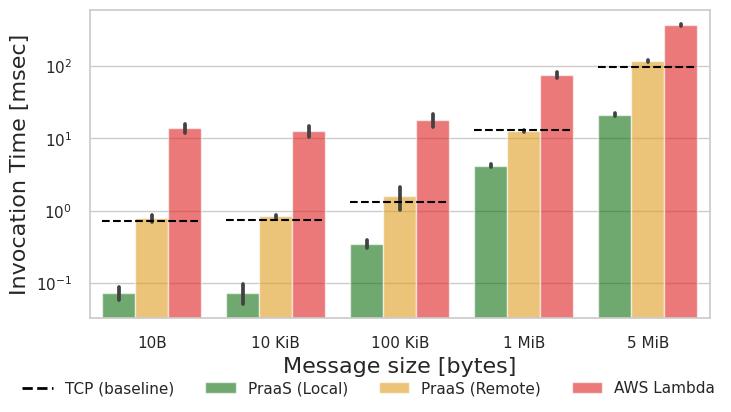

In [3]:

ax = plt.gca()


color = ['green','orange','red','blue','limegreen','darkgreen','royalblue','navy']


sns.barplot(
    data=data_praas,
    x="size", y="time", hue="type", hue_order=["praas_local", "praas_remote", "aws"],
    errorbar="sd", alpha=.6,#, height=6,
    estimator=p50_estimator, palette=color,
    ax=ax
)

prop = dict(arrowstyle="-|>,head_width=0.4,head_length=0.8",color='black',shrinkA=0,shrinkB=0)

#plt.annotate("", ha='left',xy=(0.1,2), xytext=(0.3,25), arrowprops=prop)
#ax.arrow(0.3, 25, -0.2, -23, head_width=0.1, head_length=0.4, fc='k', ec='k')
#plt.annotate("94% Reduction", ha='left',xy=(0,25), xytext=(0,25))
#plt.annotate("", ha='left',xy=(1.1,2), xytext=(1.3,25), arrowprops=prop)
#ax.arrow(0.3, 25, -0.2, -23, head_width=0.1, head_length=0.4, fc='k', ec='k')
#plt.annotate("93% Reduction", ha='left',xy=(1,25), xytext=(1,25))


#plt.annotate("94%, 93%, 91%, 83% and 69% latency reduction against Lambda", ha='left',xy=(-0.5,150), xytext=(-0.5,150))
#plt.annotate("", ha='left',xy=(1.1,2), xytext=(1.1,100), arrowprops=prop)
#plt.annotate("", ha='left',xy=(0.1,2), xytext=(0.1,100), arrowprops=prop)
#plt.annotate("", ha='left',xy=(2.1,2), xytext=(2.1,100), arrowprops=prop)
#plt.annotate("", ha='left',xy=(3.1,2), xytext=(3.1,100), arrowprops=prop)

i = 0
lats = []
for size in [10, 1024, 102400, 1048576, 5242880]:
    lat = ethernet_data.loc[(ethernet_data['type'] == 'ethernet') & (ethernet_data['size'] == size)]['time'].median()
    lats.append(lat)
    
print(lats)
ax.axhline(xmin=0.02 + i, xmax = 0.18 + i, y=lats[0], color='black', linestyle='--')
ax.axhline(xmin=0.22 + i, xmax = 0.38 + i, y=lats[1], color='black', linestyle='--')
ax.axhline(xmin=0.42 + i, xmax = 0.58 + i, y=lats[2], color='black', linestyle='--')
ax.axhline(xmin=0.62 + i, xmax = 0.78 + i, y=lats[3], color='black', linestyle='--')
ax.axhline(xmin=0.82 + i, xmax = 0.98 + i, y=lats[4], color='black', linestyle='--')
    

#ax.despine(left=True)
ax.set_yscale("log")
ax.set_xlabel('Message size [bytes]',fontsize=16)
ax.set_ylabel('Invocation Time [msec]',fontsize=16)
ax.set_title("")

ax.set_xticklabels(['10B', '10 KiB', '100 KiB', '1 MiB', '5 MiB'])

import copy
import matplotlib.patches as mpatches

from matplotlib.lines import Line2D
#p = copy.copy(ax.get_legend_handles_labels()[0][0])
#print(dir(p.patches[0]))
#print(p.patches[1].set_color('black'))
#print(p.patches[2])
#print(p.patches[3])
#print(p.patches[4])
#print(ax.get_legend_handles_labels()[0][0].patches
p = Line2D([0], [0], color='black', ls='--',lw=2, label='black')
red_patch = mpatches.Patch(color='black', label='The red data')
ax.legend(loc='center', bbox_to_anchor=(0.45, -0.23),
    handles=[p, *ax.get_legend_handles_labels()[0]],
    labels=['TCP (baseline)', 'PraaS (Local)', 'PraaS (Remote)', 'AWS Lambda'],
    ncols=4        
)

import scienceplots

#plt.style.use(["science", "high-contrast", "ieee"])
ax.figure.savefig("dataplane_latency.pdf",bbox_inches='tight',pad_inches = 0, transparent=False)

In [4]:
for size in [10, 1024, 102400, 1048576, 5242880]:
    #print('Warm Latency', data_praas.loc[(data_praas['type'] == 'praas_local') & (data_praas['size'] == size)]['time'].median())
    #print('Hot Latency', data_praas.loc[(data_praas['type'] == 'praas_remote') & (data_praas['size'] == size)]['time'].median())
    #print('AWS', data_praas.loc[(data_praas['type'] == 'aws') & (data_praas['size'] == size)]['time'].median())
    print(size, 'remote', 1-(data_praas.loc[(data_praas['type'] == 'praas_remote') & (data_praas['size'] == size)]['time'].median()/data_praas.loc[(data_praas['type'] == 'aws') & (data_praas['size'] == size)]['time'].median()))
    
print('')


for size in [10, 1024, 102400, 1048576, 5242880]:
    #print('Warm Latency', data_praas.loc[(data_praas['type'] == 'praas_local') & (data_praas['size'] == size)]['time'].median())
    #print('Hot Latency', data_praas.loc[(data_praas['type'] == 'praas_remote') & (data_praas['size'] == size)]['time'].median())
    #print('AWS', data_praas.loc[(data_praas['type'] == 'aws') & (data_praas['size'] == size)]['time'].median())
    print(size, 'local', 1-(data_praas.loc[(data_praas['type'] == 'praas_local') & (data_praas['size'] == size)]['time'].median()/data_praas.loc[(data_praas['type'] == 'aws') & (data_praas['size'] == size)]['time'].median()))

10 remote 0.9423401649769251
1024 remote 0.9335086983197103
102400 remote 0.9126346503053981
1048576 remote 0.8318812428026492
5242880 remote 0.6861301520930019

10 local 0.9946713543370035
1024 local 0.9941360856571734
102400 local 0.980753920651516
1048576 local 0.9445575295285682
5242880 local 0.9423543480434953


In [5]:

data_docker = pd.read_csv(os.path.join(data_path, 'praas_local', 'dataplane_sizes_fargate_local_docker.csv'))
#data.set_index('id', drop=True, inplace=True)
data_docker['time'] /= 1000.0 * 1000.0
data_docker['type'] = 'praas_local'
data_docker.drop(['repetition'], axis=1, inplace=True)

data_cpu = pd.read_csv(os.path.join(data_path, 'praas_local', 'dataplane_sizes_fargate_local_1cpu.csv'))
#data.set_index('id', drop=True, inplace=True)
data_cpu['time'] /= 1000.0 * 1000.0
data_cpu['type'] = 'praas_local'
data_cpu.drop(['repetition'], axis=1, inplace=True)

for size in [10, 1024, 102400, 1048576, 5242880]:
    #print('Warm Latency', data_praas.loc[(data_praas['type'] == 'praas_local') & (data_praas['size'] == size)]['time'].median())
    #print('Hot Latency', data_praas.loc[(data_praas['type'] == 'praas_remote') & (data_praas['size'] == size)]['time'].median())
    #print('AWS', data_praas.loc[(data_praas['type'] == 'aws') & (data_praas['size'] == size)]['time'].median())
    
    local = data_praas.loc[(data_praas['type'] == 'praas_local') & (data_praas['size'] == size)]['time'].median()
    cpu = data_cpu.loc[(data_cpu['type'] == 'praas_local') & (data_cpu['size'] == size)]['time'].median()
    docker = data_docker.loc[(data_docker['type'] == 'praas_local') & (data_docker['size'] == size)]['time'].median()
    print(docker, local)
    print('1CPU', 1 - cpu/local)
    print('Docker', local/docker)
    

0.0637885 0.07331950000000001
1CPU 0.06796282025927636
Docker 1.1494156470210148
0.0659865 0.0740715
1CPU 0.07297003570874083
Docker 1.1225250619444886
0.294107 0.34975900000000004
1CPU 0.13810509522271064
Docker 1.1892236498961264
3.2509865 4.19101
1CPU 0.11862104838690435
Docker 1.289150231783491
17.2484045 21.327219499999998
1CPU 0.07364070595325367
Docker 1.2364749156943762
